# CS 203 - Assignment 5
---

**Team Number:** 13

**Members:**

- Kain Harshil Shivkumar (23110151)  
- Jeet Joshi (23110148)

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Task 1: Data Augmentation

### Installing and Importing the Dependencies for Task 1

In [62]:
!pip install augly

In [63]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from numpy import asarray, save
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import augly.image as imaugs
from PIL import Image
import random

### Saving Images to the Directories Made

In [64]:
# Defining dataset location
folder = "/content/drive/MyDrive"
classes = ['cats', 'dogs']
train_file_name = "train"
test_file_name = "test"

# Creating train-test split (80:20)
def create_split():
    train_path = f"{folder}/{train_file_name}"
    test_path = f"{folder}/{test_file_name}"

    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    for cls in classes:
        cls_images = os.listdir(f"{folder}/Images/{cls}")
        train_files, test_files = train_test_split(cls_images, test_size=0.2, random_state=42)

        os.makedirs(f"{train_path}/{cls}", exist_ok=True)
        os.makedirs(f"{test_path}/{cls}", exist_ok=True)

        for f in train_files:
            shutil.copy(f"{folder}/Images/{cls}/{f}", f"{train_path}/{cls}/{f}")
        for f in test_files:
            shutil.copy(f"{folder}/Images/{cls}/{f}", f"{test_path}/{cls}/{f}")

    print("Train-Test Split Created (80:20).")

create_split()

# Saving original dataset
def prepare_data(split):
    images, labels = [], []
    for cls in classes:
        cls_dir = f"{folder}/{split}/{cls}"
        for file in os.listdir(cls_dir):
            img = load_img(f"{cls_dir}/{file}", target_size=(224, 224))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(1.0 if cls == 'dogs' else 0.0)
    return asarray(images), asarray(labels)

train_imgs_original, train_labels_original = prepare_data(train_file_name)
test_imgs_original, test_labels_original = prepare_data(test_file_name)

save('train_imgs_original.npy', train_imgs_original)
save('train_labels_original.npy', train_labels_original)
save('test_imgs_original.npy', test_imgs_original)
save('test_labels_original.npy', test_labels_original)

# Converting to channels-first format (no. of channels (here 3) as first index)
train_imgs_original = np.transpose(train_imgs_original, (0, 3, 1, 2))
test_imgs_original = np.transpose(test_imgs_original, (0, 3, 1, 2))

print("\n")
print("Original Dataset Shapes:")
print(f"Train: {train_imgs_original.shape}, {train_labels_original.shape}")
print(f"Test: {test_imgs_original.shape}, {test_labels_original.shape}")

Train-Test Split Created (80:20).


Original Dataset Shapes:
Train: (112, 3, 224, 224), (112,)
Test: (28, 3, 224, 224), (28,)


### Augmenting the Images and Adding it to the Formed Directories

In [65]:
# Data augmentation
def augment_image(img_path, output_dir):
    img = Image.open(img_path)

    augmentations = [
        lambda x: imaugs.rotate(x, degrees=15),
        lambda x: imaugs.crop(x, x1=0.1, y1=0.1, x2=0.9, y2=0.9),
        lambda x: imaugs.blur(x, radius=1.5),
        lambda x: imaugs.hflip(x),
        lambda x: imaugs.vflip(x),
        lambda x: imaugs.pad_square(x, color=(255, 255, 255)),
        lambda x: imaugs.scale(x, factor=0.85),
        lambda x: imaugs.grayscale(x),
        lambda x: imaugs.color_jitter(x, brightness_factor=1.2, contrast_factor=1.2, saturation_factor=1.4),
        lambda x: imaugs.overlay_text(x, text=[3], font_size=0.2, opacity=0.8),
    ]

    random.shuffle(augmentations)

    # Creating 2 augmented versions per image
    for i in range(2):
        aug_img = img.copy()
        selected_augs = augmentations[i * 3 : (i + 1) * 3]
        for aug_fn in selected_augs:
            aug_img = aug_fn(aug_img)
        aug_img.save(f"{output_dir}/aug_{i}_{os.path.basename(img_path)}")

# Applying augmentation to train set
for cls in classes:
    cls_dir = f"{folder}/{train_file_name}/{cls}"
    for file in os.listdir(cls_dir):
        if not file.startswith('aug_'):
            augment_image(f"{cls_dir}/{file}", cls_dir)

print("Data Augmentation Completed.")

# Saving augmented dataset
train_imgs_aug, train_labels_aug = prepare_data(train_file_name)

save('train_imgs.npy', train_imgs_aug)
save('train_labels.npy', train_labels_aug)

# Converting to channels-first format (3 (RGB) as first imdex)
train_imgs_aug = np.transpose(train_imgs_aug, (0, 3, 1, 2))

print("\n")
print("Augmented Dataset Shapes:")
print(f"Train: {train_imgs_aug.shape}, {train_labels_aug.shape}")

Data Augmentation Completed.


Augmented Dataset Shapes:
Train: (336, 3, 224, 224), (336,)


### Counting the Images in Different Classes and Plotting Them

Original Train Dataset Counts: {'cats': 56, 'dogs': 56}
Augmented Train Dataset Counts: {'cats': 168, 'dogs': 168}
Test Dataset Counts: {'cats': 14, 'dogs': 14}


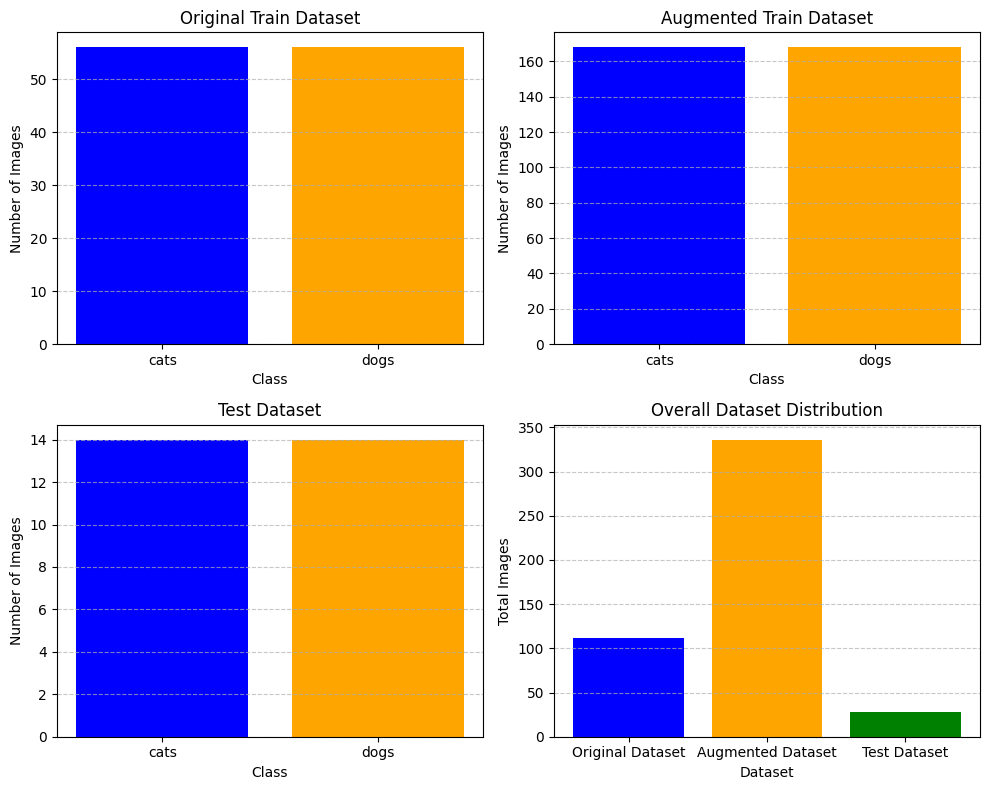

In [66]:
def count_images(directory, exclude_augmented=False):
    class_counts = {}
    for cls in classes:
        cls_dir = f"{directory}/{cls}"
        # Excluding augmented images
        if exclude_augmented:
            images = [f for f in os.listdir(cls_dir) if not f.startswith("aug_")]
        else:
            images = os.listdir(cls_dir)  # Count all images
        class_counts[cls] = len(images)
    return class_counts

# Counting original images (excluding augmented ones)
train_counts_original = count_images(f"{folder}/{train_file_name}", exclude_augmented=True)
test_counts_original = count_images(f"{folder}/{test_file_name}", exclude_augmented=True)

# Counting augmented images (including augmented ones)
train_counts_aug = count_images(f"{folder}/{train_file_name}", exclude_augmented=False)

# Printing counts
print("Original Train Dataset Counts:", train_counts_original)
print("Augmented Train Dataset Counts:", train_counts_aug)
print("Test Dataset Counts:", test_counts_original)

# Function to plot class distributions in a single figure
def plot_class_distributions(counts_list, titles):
    plt.figure(figsize=(10,8))

    # Plotting class-wise distributions
    for i, (counts, title) in enumerate(zip(counts_list, titles), 1):
        plt.subplot(2, 2, i)
        plt.bar(counts.keys(), counts.values(), color=['blue', 'orange'])
        plt.xlabel("Class")
        plt.ylabel("Number of Images")
        plt.title(title)
        plt.xticks(rotation=0)
        plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Plotting total counts
    total_counts = [sum(counts.values()) for counts in counts_list]

    plt.subplot(2, 2, 4)
    plt.bar(["Original Dataset", "Augmented Dataset", "Test Dataset"], total_counts, color=['blue', 'orange', 'green'])
    plt.xlabel("Dataset")
    plt.ylabel("Total Images")
    plt.title("Overall Dataset Distribution")
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()

# List of datasets and their titles
counts_list = [train_counts_original, train_counts_aug, test_counts_original]
titles = ["Original Train Dataset", "Augmented Train Dataset", "Test Dataset"]

# Plotting all distributions
plot_class_distributions(counts_list, titles)


## Task 2: Model Training

### Importing the Dependencies for Task 2

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import AutoImageProcessor, ResNetForImageClassification
from torchvision import transforms
from PIL import Image
import os

### Model Architecture for ResNet50 Model

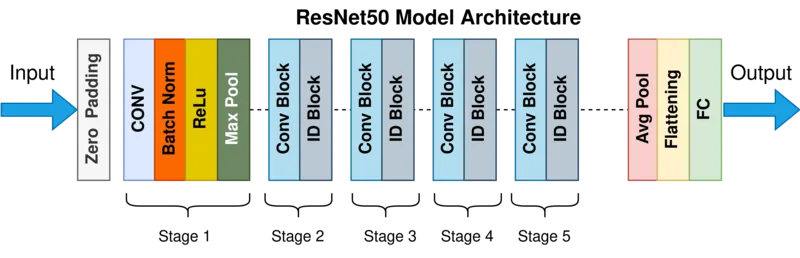

### Summary of the Model Parameters

In [68]:
import torch
import torchvision.models as models
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading ResNet-50 model
model = models.resnet50(pretrained=False).to(device)

# Modifying the final fully connected (FC) layer for binary classification
num_classes = 2
model.fc = torch.nn.Linear(model.fc.in_features, num_classes).to(device)

# Printing model summary
summary(model, (3, 224, 224), device=str(device))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### Model Training

In [85]:
# Defining path
data_dir = "/content"

# Loading Datasets
def load_data():
    """Loading original and augmented datasets."""
    train_imgs = np.load(os.path.join(data_dir, "train_imgs_original.npy"))
    aug_train_imgs = np.load(os.path.join(data_dir, "train_imgs.npy"))
    train_labels = np.load(os.path.join(data_dir, "train_labels_original.npy"))
    aug_train_labels = np.load(os.path.join(data_dir, "train_labels.npy"))
    test_imgs = np.load(os.path.join(data_dir, "test_imgs_original.npy"))
    test_labels = np.load(os.path.join(data_dir, "test_labels_original.npy"))

    # Converting shape
    train_imgs = np.transpose(train_imgs, (0, 3, 1, 2))
    aug_train_imgs = np.transpose(aug_train_imgs, (0, 3, 1, 2))
    test_imgs = np.transpose(test_imgs, (0, 3, 1, 2))

    return train_imgs, aug_train_imgs, train_labels, aug_train_labels, test_imgs, test_labels

train_imgs, aug_train_imgs, train_labels, aug_train_labels, test_imgs, test_labels = load_data()

# Converting data to tensors
train_imgs = torch.tensor(train_imgs, dtype=torch.float32)
aug_train_imgs = torch.tensor(aug_train_imgs, dtype=torch.float32)
test_imgs = torch.tensor(test_imgs, dtype=torch.float32)

# Converting labels to tensors
train_labels = torch.tensor(train_labels, dtype=torch.long)
aug_train_labels = torch.tensor(aug_train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

# Creating dataloaders
batch_size = 16

train_dataset_original = TensorDataset(train_imgs, train_labels)
train_dataset_augmented = TensorDataset(aug_train_imgs, aug_train_labels)
test_dataset = TensorDataset(test_imgs, test_labels)

train_loader_original = DataLoader(train_dataset_original, batch_size=batch_size, shuffle=True)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Loading Pretrained ResNet Models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_original = ResNetForImageClassification.from_pretrained("microsoft/resnet-50", num_labels=2, ignore_mismatched_sizes=True).to(device)
model_augmented = ResNetForImageClassification.from_pretrained("microsoft/resnet-50", num_labels=2, ignore_mismatched_sizes=True).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_original = optim.AdamW(model_original.parameters(), lr=2e-5, weight_decay=0.01)
optimizer_augmented = optim.AdamW(model_augmented.parameters(), lr=2e-5, weight_decay=0.01)

# Training Function
def train_model(model, optimizer, train_loader, model_name, epochs=10):
    """Training the model and returning evaluation metrics."""
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    acc, prec, rec, f1, all_labels, all_preds = evaluate_model(model, test_loader)
    return (acc, prec, rec, f1), all_labels, all_preds

# Evaluation Function
def evaluate_model(model, test_loader):
    """Evaluate the model on the test set."""
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    print(f"Test Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")

    return acc, prec, rec, f1, all_labels, all_preds  # Returning Labels & Predictions

# Training and Comparing Both Models
print("\n Training on Original Dataset")
metrics_original, all_labels_original, all_preds_original = train_model(
    model_original, optimizer_original, train_loader_original, "resnet_original", epochs=10)

print("\n Training on Augmented Dataset")
metrics_augmented, all_labels_augmented, all_preds_augmented = train_model(
    model_augmented, optimizer_augmented, train_loader_augmented, "resnet_augmented", epochs=10)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-


 Training on Original Dataset
Epoch [1/10], Loss: 4.8211, Train Accuracy: 0.5357
Epoch [2/10], Loss: 4.7795, Train Accuracy: 0.5625
Epoch [3/10], Loss: 4.7567, Train Accuracy: 0.5804
Epoch [4/10], Loss: 4.7217, Train Accuracy: 0.6696
Epoch [5/10], Loss: 4.6654, Train Accuracy: 0.7232
Epoch [6/10], Loss: 4.6215, Train Accuracy: 0.7500
Epoch [7/10], Loss: 4.6158, Train Accuracy: 0.8125
Epoch [8/10], Loss: 4.5138, Train Accuracy: 0.8125
Epoch [9/10], Loss: 4.4964, Train Accuracy: 0.8661
Epoch [10/10], Loss: 4.4566, Train Accuracy: 0.8839
Test Accuracy: 0.7500, Precision: 0.6842, Recall: 0.9286, F1-score: 0.7879

 Training on Augmented Dataset
Epoch [1/10], Loss: 14.5148, Train Accuracy: 0.5119
Epoch [2/10], Loss: 14.2600, Train Accuracy: 0.5357
Epoch [3/10], Loss: 14.0698, Train Accuracy: 0.5982
Epoch [4/10], Loss: 13.8204, Train Accuracy: 0.6756
Epoch [5/10], Loss: 13.6191, Train Accuracy: 0.7321
Epoch [6/10], Loss: 13.3539, Train Accuracy: 0.7976
Epoch [7/10], Loss: 13.2187, Train Accu

### Printing and Comparing Results

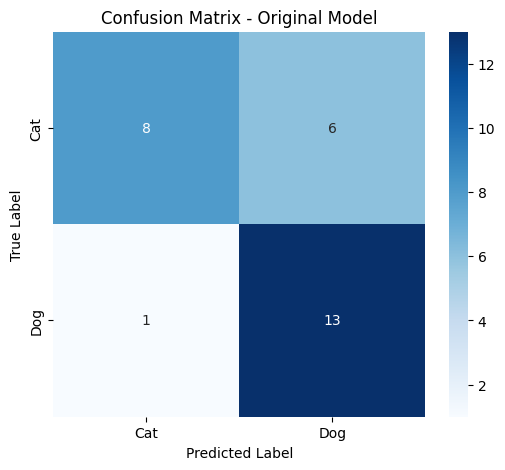

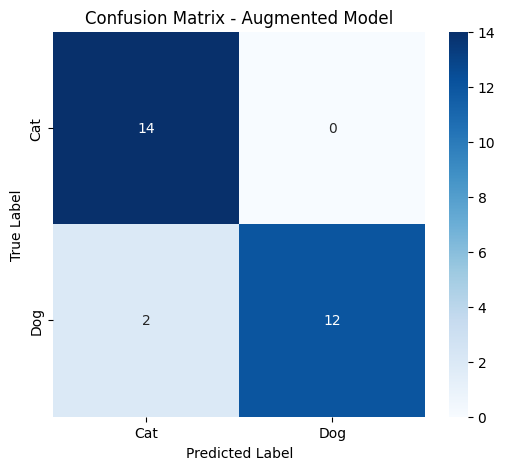

In [87]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Computing Confusion Matrices for both models
conf_matrix_original = confusion_matrix(all_labels_original , all_preds_original)
conf_matrix_augmented = confusion_matrix(all_labels_augmented, all_preds_augmented)

# Class labels
class_labels = ["Cat", "Dog"]

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

# Plotting both confusion matrices
plot_confusion_matrix(conf_matrix_original, "Confusion Matrix - Original Model")
plot_confusion_matrix(conf_matrix_augmented, "Confusion Matrix - Augmented Model")

In [88]:
# Getting metrics
acc_orig, prec_orig, rec_orig, f1_orig = metrics_original
acc_aug, prec_aug, rec_aug, f1_aug = metrics_augmented

# Printing and Comparing Results
print("Performance Comparison")
print(f"Original Model: Accuracy: {acc_orig:.4f}, Precision: {prec_orig:.4f}, Recall: {rec_orig:.4f}, F1-score: {f1_orig:.4f}")
print(f"Augmented Model: Accuracy: {acc_aug:.4f}, Precision: {prec_aug:.4f}, Recall: {rec_aug:.4f}, F1-score: {f1_aug:.4f}")

Performance Comparison
Original Model: Accuracy: 0.7500, Precision: 0.6842, Recall: 0.9286, F1-score: 0.7879
Augmented Model: Accuracy: 0.9286, Precision: 1.0000, Recall: 0.8571, F1-score: 0.9231


### Explaination for the Results
The original model struggles due to limited data diversity, leading to lower precision and accuracy. The augmented model performs significantly better, likely because data augmentation introduces variability, improving generalization. The perfect precision (1.0000) suggests that false positives are minimal, but recall isn't perfect, meaning some true positives are missed. The improved F1-score indicates a better balance between precision and recall. Overall, augmentation enhances robustness, helping the model generalize better to unseen data.